In [1]:
# March 2022

# for communication

# twitter https://twitter.com/runaz_there

# Линейная регрессия

In [2]:
# ! pip install pingouin --upgrade
# ! pip install mlxtend
# ! pip install matplotlib
# ! pip install pyod --upgrade

In [3]:
import pandas as pd  # для работы с датафреймом
import numpy as np  # для вычислений
import matplotlib.pyplot as plt  # для графиков
import seaborn as sns  # для графиков
import statsmodels.api as sm  # для статистического анализа
from scipy import stats  # для статистического анализа
from mlxtend.evaluate import permutation_test  # перестановочный тест
import pingouin as pg  # для статистического анализа
import patsy
import os
from papanda import gesd # библиотека для обнаружения выбросов
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split  # для деления на обучающую и тестовую выборки
from sklearn.impute import SimpleImputer  # для заполнения пропусков
from sklearn.preprocessing import OneHotEncoder  # для кодирования категориальных переменных
from sklearn.pipeline import Pipeline  # для обработки данных для машинного обучения
from sklearn.preprocessing import StandardScaler # стандартизация данных
from sklearn.compose import ColumnTransformer # для обработки данных для машинного обучения
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV

from pyod.models.knn import KNN

# Введение

В науке цель, как правило, определить характеристику взаимосвязи между независимой и зависимой переменными. В машинном обучении цель - научиться прогнозировать зависимую переменную по независимым. Поэтому линейную регрессию можно рассматривать с каждой из указанных сторон.

Линейная регрессия является методом машинного обучения. Это означает, что линейная регрессия применяется для построения модели, которая обучается на имеющихся данных, чтобы научиться делать предсказания на новых данных. В основе линейной регрессии два предположения: зависимая переменная может быть представлена как сумма взвешенных независимых признаков плюс ошибка (шум); ошибка подчиняется известному распределению. 

Методы машинного обучения можно разделить на:

1) обучение с учителем;
2) обучение без учителя;
3) обучение с подкреплением.

Также методы машинного обучения можно разделить на:
1) решение задачи регрессии (для непрерывных числовых данных);
2) решение задачи классификации (для категориальных данных).

Вот общая картина методов машинного обучения:

![Машинное обучение](./images/metod_ml.jpg 'Машинное обучение')

Линейная регрессия относится к методом обучения с учителем. Это предполагает, что есть данные, которые используются для обучения. Эти данные разделены на:

1) независимые переменные (или просто переменные);
2) зависимые переменные.

Терминология в машинном обучении значительно отличается от учебника к учебнику. Однако в этой и последующих главах я буду использовать терминологию, которая введена выше.

Обратимся сразу к примеру на основе данных о книгах:

**num_pages**, **language_code** - это переменные,
**average_rating** - зависимая переменная.

Обучение с учителем означает, что надо взять переменные и на их основе с помощью математических операций найти связи с зависимой переменной. Характер этой связи между переменными и целевой переменнойм: конкретные значения переменных определяют конкретную зависимую переменную. 

Визуализировать это можно еще следующим образом. Представлю таблицу. В таблице по горизонтали - строки, по вертикали - столбцы. Одна строка - это одно наблюдение (в данном случае - одна книга). Столбцы, относящиеся к этой строке, - это признаки данного конкретного наблюдения (количество страниц, количество обзоров и т.п.). Среди столбцов выделяю зависимую переменную - средняя оценка. Это то, что хочется научиться предсказывать. Остальные столбцы - это переменные. Цель - на основании оставшихся столбцов (переменных) определить зависимую переменную.

Все методы машинного обучения предполагают, что выполняются условия их применимости. Здесь все обстоит также, как и при применении статистических методов.

Применение линейной регрессии предполагает выполнение следующих условий: 
* зависимая переменная - непрерывная величина, переменные - могут быть непрерывной или категориальной (как правило, дихотамической) переменной;
* оценка одной книги не зависит от оценки другой. Определяется исследователем;
* линейность отношений. Проверяется по графику. Например, в случае, если дан один независимые признак и зависимый признак, график строится так: по **x** расположены значения признака, по **y** расположены значения зависимого признака;
* непрерывные переменные должны быть нормально распределены и не должны иметь выбросов. Из статистического анализа во второй главе проекта известно, что данные не распределены нормально. Однако в некоторых руководствах встречается утверждение, что данное условие не является обязательным. Кроме того, как указывалось в той же главе 2, если объем данных большой, то можно положиться на центральную предельную теорему, то есть считать, что требование о нормальном распределении выполняется;
* гомоскедастичность, то есть постоянство ошибок предсказания модели. Это проверяется уже после построения модели на графике остатков;
* нормальность распределения ошибок. Это также проверяется уже после построения модели, можно использовать гистограмму по остаткам. Кроме того, среднее ошибок должно быть равно нулю;
* если используется два и более признака, то необходима проверка на мультиколлинеарность. И это проверяется после построения модели, но с помощью специальных тестов.
* масштабирование данных. Это не является собственно условием применения линейной регрессии. Однако масштабирование требуется практически для всех методов машинного обучения, особенно в случае, если предполагается рассмотрение влияния на зависимую переменную не отдельных переменных, а их взаимосвязей. Если одна переменная выражена в миллионах, а другая в сотнях, то первая будет иметь больший вес уже только в силу этого. В отдельных руководствах утверждается, что, как правило, не требуется масштабирование зависимой переменной.

При применении методов машинного обучения надо помнить следующую рекомендацию: всегда надо искать самый простой способ решения задачи. Если линейная регрессия будет хорошо справляться, то использовать более сложные способы не надо. Если же эти сложные способы дадут незначительное улучшение, то также не надо их использовать, если это ведет к излишней трате вычислительного времени. Поэтому более сложные методы можно использовать, если:

1) регрессия к нашей задаче не подходит;
2) другой метод не только лучше себя показывает, но и находится на том же уровне эффективности (или выше).

Дополнительно стоит отметить следующее. Даже полное соответствие данных указанным выше условиям и применение самого продвинутого метода обучения с самым лучшим набором параметров не означает, что удастся получить модель, которая будет хорошо работать. В некоторых публикациях встречается, и даже доказывается, утверждение, что главное значение имеет не столько применяемый метод машинного обучения, сколько качество данных. 

Линейная регрессия может быть применена различными способами и с помощью разлинчых библиотек. Все эти способы условно можно разделить на три подхода:

1) визуальный;
2) статистический;
3) собственно машинное обучение.

Это деление является условным и необходимо только для лучшего понимания материала ниже.

**Внимание!**

Линейная регрессия имеет важное ограничение. При предсказаниях на основе линейной модели нельзя выходить за границы данных, по которым обучена модель. Если модель обучена по максимальной цене в 10, то нельзя предсказывать для цены в 100.

После этих вводных замечаний подробнее остановлюсь на описании непосредственно линейной регрессии.

Большинство методов, используемых в Data Science, являются либо регрессией, либо построенны на основе регрессии. Поэтому изучение линейной регрессии имеет важное значение. 

Простая регрессионная линейная модель имеет следующий вид

![Линейная регрессия](./images/linreg.png 'Линейная регрессия')

Что означает эта формула? **t** - это конкретное наблюдение в выборке. Общее число наблюдений в выборке обозначается через **n**. Поэтому **t** может в конкретной выборке изменяться от 1 до **n**. Каждое наблюдение делится на зависимую переменную **y** и значение единственной независимой переменной **x** (объясняющая переменная). В более сложных моделях независимых переменных может быть две и более.

Так как используется формула, то здесь как бы связывается зависимая переменная с независимой переменной. Но чтобы перейти от независимой переменной к зависимой также используются два коэффициента: один умножаем, а другой прибавляем. Кроме того, так как нет уверенности, что применение коэффициентов может однозначно превести от независимой переменной к зависимой, надо также использовать коэффициент ошибки. Отсюда получается, что в формуле всего пять величин: **y** и **x** наблюдаемы (то есть их можно найти в изначальных данных), три величины (коэффициенты) - не наблюдаемы. Важно также учитывать, что если зависимая переменная, независимая переменная и коэффициент ошибки относятся к конкретному наблюдению, то оставшиеся два коэффициента относятся ко всем наблюдениям в данных.

Из учебника Дэвидсона: "Как правило, к ошибкам применяются следующие требования: среднее должно быть равно нулю, они должны быть распределены одинаково и не зависят друг от друга. Про ошибку в формуле надо понимать следующее. Эта ошибка отражает наше незнание конкретно процесса. Точнее, что мы не можем знать все обстоятельства процесса. При этом мы стремимся к тому, чтобы ошибка была с нулевым средним, то есть, чтобы значения, которые определяют Y, с равной вероятностью могли бы делать Y как больше, так и меньше реального значения".

Как правило, линейная регрессия записывается в матричной форме. Вот как это выглядит. Посмотрю сначала на формумулу выше, а затем представлю, что эта формула записана для каждой строки моего набора данных. Это уже само по себе как бы задает матрицу, которая формально будет выглядеть следующим образом.

![Линейная регрессия матрица](./images/linreg2.png 'Линейная регрессия матрица')

Теперь изначальную формулу линейной регрессии можно записать так

![Линейная регрессия матрица](./images/linreg3.png 'Линейная регрессия матрица')

Графически представить линейную регрессию можно так

![Линейная регрессия график](./images/linreg5.png 'Линейная регрессия матрица')

Этот рисунок взят со стр. 379 учебника Машинное обучение.

Теперь задача - оценить модель, то есть подобрать коэффициенты. Это делается с учетом принципа, что математическое ожидание ошибки равно нулю. Более подробно об этом можно прочитать на стр. 52 и далее в учебнике Дэвидсона. 

Способы оценки есть различные, самые популярные - метод наименьших квадратов и метод наибольшего правдоподобия. В матричной форме нахождение коэффициентов с помощью метода наименьших квадратов записывается так:

![Линейная регрессия матрица](./images/linreg4.png 'Линейная регрессия матрица')

Метод наименьших квадратов не всегда удовлетворителен. Вот как это объясняют в учебнике Основы обучения. "Первая причина - это точность предсказания. Оценки по методу наименьших квадратов часто имеют малое смещение, но большую дисперсию. Точность предсказания иногда можно улучшить путем сжатия, или обнуления некоторых коэффициентов. При этом мы жертвуем небольшим смещением, чтобы уменьшить дисперсию прогнозируемых значений, и, следовательно, можем улучшить общую точность предсказания. Вторая причина - это интерпретация. Часто при большом количестве предикторов мы хотели бы определить меньшее подмножество, которое оказывает сильное влияние. Чтобы получить общую картину, мы готовы пожертвовать некоторыми мелкими деталями".

**Дополнительные замечания:**
1. Соотношение дисперсии, смещения и сложности модели - гл. 7 учебника Основы обучения. Интересный рисунок в начале главы:

![Смещение](./images/bias.png 'Смещение')

Голубая кривая - это ошибка обучения, розовая - ошибка тестирования. По оси X указана сложность модели. В левом верхнем углу видно, что смещение является большим, то есть модель допускает серьезную ошибку по сравнению с истинными значениями. Однако дисперсия, то есть разброс таких ошибочных значений, меньше. А вот в правом углу видно, что смещение становится меньше, зато дисперсия больше. 

Поэтому авторы замечают: "В целом по мере увеличения сложности модели в нашей процедуре дисперсия имеет тенденцию к увеличению, а квадрат смещения имеет тенденцию к уменьшению. При уменьшении сложности модели возникает противоположное поведение".

В тоже время само понятие "сложности модели" оценочное. В онлайн-учебнике ML сказано так: "Что именно представляет собой сложность модели, является сложным вопросом. Многие факторы определяют, будет ли модель хорошо обобщаться. Например, модель с большим количеством параметров может считаться более сложной. Модель, параметры которой могут принимать более широкий диапазон значений, может быть более сложной. Часто в случае с нейронными сетями мы считаем модель, которая требует большего количества обучающих итераций, более сложной, а модель, подлежащую ранней остановке (меньшее количество обучающих итераций), менее сложной".

2. Деление набора данных на три части. В учебнике Основы обучения рекомендуется следующее. "Если есть большое количество данных, то лучший подход для решения обеих задач состоит в том, чтобы случайным образом разделить множество данных на три части: обучающее, контрольное и тестовое множество. Обучающее множество используется для настройки моделей; контрольное множество - для оценки ошибки предсказания при выборе модели; тестовое множество - для оценки ошибки обобщения окончательно выбранной модели. В идеале тестовое множество должно храниться в запасе и использоваться только в конце анализа данных... Типипчное разделение может составлять 50% для обучения и по 25% для проверки и тестирования" (стр. 246).

3. В рамках моделирования стоит две задачи: выбор модели (оценить качество различных моделей и выбрать лучшую); оценка модели (когда выбрали лучшую модель, то надо оценить ее ошибку предсказания (ошибку обобщения) на новых данных).

4. Подробнее про метод опорных векторов - гл. 12, метод главных компонент - гл. 14.5. Все из учебника Основы обучения. Дополнительно по методу главных компонент - гл. 5 учебника Машинное обучение и [6.5.5. Principal Components](https://www.itl.nist.gov/div898/handbook/pmc/section5/pmc55.htm).

5. Базовые коцепции линейной алгебры - гл. 2 учебника Машинное обучение, гл. 2 учебника Дэвидсона. Дополнительно по линейной алгебре см. хорошее руководство [Introduction to Linear Algebra for Applied Machine Learning with Python](https://pabloinsente.github.io/intro-linear-algebra#singular-value-decomposition-theorem)

6. Терминология, которую используют при построеннии моделей см. [4.1.2. What terminology do statisticians use to
describe process models?](https://www.itl.nist.gov/div898/handbook/pmd/section1/pmd12.htm). Также см. [4.3.2. Why is experimental design important for process modeling?](https://www.itl.nist.gov/div898/handbook/pmd/section3/pmd32.htm). Пример анализа из учебника для инженеров см. в [5.4.7.1. Full factorial example](https://www.itl.nist.gov/div898/handbook/pri/section4/pri471.htm). Шаги для настройки модели с объяснением см. в [5.4.7.3. Response surface model example](https://www.itl.nist.gov/div898/handbook/pri/section4/pri473.htm)

7. В учебнике для инженеров указано, что на практике зачастую предположения, которые требуются для применения модели прогнозирования, могут быть незначительно нарушены. Только исследователь может решить, насколько эти конкретные нарушения не позволяют использовать модель.

8. О загрузке данных небольшими пакетами (батчами) см. стр. 332-333 учебника Машинное обучение.

9. в общем случае символ “шляпа” над параметрами и другими буквенными обозначениями означает, что речь идет об оценке, прогнозируемом значении.

10. Ниже по тексту будет представлен статистический подход и машинное обучение. Я уже указывал, что такое деление связано, прежде всего, с конечной целью исследования. Статистический подход направлен на то, чтобы понять отношения между переменными, а машинное обучение направлено на прогнозирование. Однако еще один момент состоит в том, что статистический подход стремится также оценить параметры модели: насколько они вероятны, как выборочные параметры связаны с параметрами для генеральной совокупности и т.п. Машинное обучение этот этап игнорирует, так как использует большие объемы данных и полагаетcz на предельную центральную теорему. Однако машинное обучение имеет свои методики для улучшения модели.

# Загрузка и описание данных

In [4]:
data = pd.read_csv(os.getcwd() + '\\gd_augmentation.csv', 
    dtype = {'decade':'object','quarter':'object', 'tra_co':'object', 'multivolume':'object'}) 

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10838 entries, 0 to 10837
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               10838 non-null  object 
 1   average_rating      10838 non-null  float64
 2   language_code       10838 non-null  object 
 3   num_pages           10838 non-null  int64  
 4   ratings_count       10838 non-null  int64  
 5   text_reviews_count  10838 non-null  int64  
 6   decade              10838 non-null  object 
 7   quarter             10838 non-null  object 
 8   tra_co              10838 non-null  object 
 9   multivolume         10838 non-null  object 
 10  len_title           10838 non-null  int64  
 11  polarity            10838 non-null  float64
 12  subjectivity        10838 non-null  float64
dtypes: float64(3), int64(4), object(6)
memory usage: 1.1+ MB


In [6]:
# удалю признаки, которые не буду рассматривать 
# работать буду с копией данных
db = data.copy()
db = db.drop(['title', 'language_code'], axis=1)
db.head()

,average_rating,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume,len_title,polarity,subjectivity
0,4.57,652,2095690,27591,2000,3,1,1,39,-0.166667,0.166667
1,4.49,870,2153167,29221,2000,3,1,1,42,0.000000,0.000000
2,4.42,352,6333,244,2000,4,0,1,40,0.000000,0.000000
3,4.56,435,2339585,36325,2000,2,1,1,41,0.000000,0.000000
4,4.78,2690,41428,164,2000,3,1,1,34,0.000000,0.000000


In [7]:
# обзор основных статистик для количественных признаков
db.describe()

,average_rating,num_pages,ratings_count,text_reviews_count,len_title,polarity,subjectivity
count,10838.000000,10838.000000,1.083800e+04,10838.000000,10838.000000,10838.000000,10838.000000
mean,3.942158,344.175217,1.834788e+04,553.074737,30.258719,0.031306,0.149035
std,0.295387,238.556381,1.138660e+05,2599.330244,22.938807,0.193648,0.270061
min,1.000000,11.000000,0.000000e+00,0.000000,2.000000,-1.000000,0.000000
25%,3.770000,203.000000,1.170000e+02,10.000000,15.000000,0.000000,0.000000
50%,3.960000,304.000000,8.035000e+02,49.000000,22.000000,0.000000,0.000000
75%,4.130000,417.000000,5.226750e+03,248.000000,39.000000,0.000000,0.250000
max,5.000000,6576.000000,4.597666e+06,94265.000000,254.000000,1.000000,1.000000


Зависимая переменная - **average_rating**. Независимые переменные - это те признаки, на которых будет обучаться модель, чтобы получить зависимую переменную. 

# Визуальный подход

Линейная регрессия может искать взаимосвязи между одной переменной и зависимой переменной. Или возможно искать взаимосвязь между множеством переменных (и их взаимосвязью) и зависимой переменной. Визуальный подход применяется, как правило, для случая, когда надо найти взаимосвязь между одной переменной и зависимой переменной. В тоже время линейная регрессия имеет несколько расширений, которые будут показаны ниже.

Важно помнить, что визуальный подход особенно хорошо работает, когда не так много данных. Как будет видно ниже, в случае, если есть более 10 тыс. наблюдений график может быть сложно прочитать.

Визуальный подход применяется для того, чтобы определить, что в данных есть линейные отношения. Другими словами, это своеобразное черновое построение линейной регрессии.

Визуальный подход позволяет также понять, что означает "взаимосвязь между переменными". При движении вдоль оси **x** значение **y** также изменяется. Если значение **y** увеличивается с увеличением по оси **x** (или уменьшается при уменьшении **x**), то речь идет о положительной (отрицательной) связи. В результате такого движения может получиться прямая линия, которая либо не имеет наклона к оси **x**, либо такой наклон имеет. Чем больше такой наклон, тем сильнее связь между признаком и целевым признаком.

<AxesSubplot:xlabel='num_pages', ylabel='average_rating'>

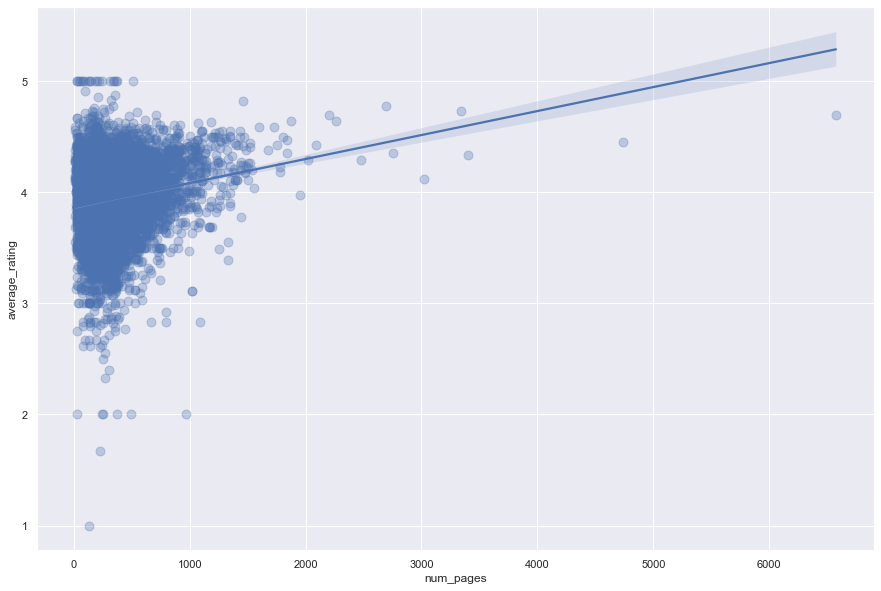

In [8]:
# стиль графика
sns.set_theme(color_codes=True)

fig, ax = plt.subplots(figsize=(15, 10)) 
sns.regplot(x='num_pages', y='average_rating', data=db, scatter_kws={'s':80, 'alpha': 0.3}) 

Интерпретировать график можно так. Точка пересечения линии регрессии с осью **y** находится в районе 3.9. Однако значения это не имеет, так как в этой точке **x** принимает значение 0, а книг с таким количество страниц не бывает. У линии есть наклон, то есть **num_pages** оказывает влияние на оценку. Наклон положительный, то есть чем больше страниц, тем выше оценка. Аналогичные графики можно построить для других переменных, однако здесь это не приводится, чтобы не усложнять анализ.

Ниже продемонстрировано несколько дополнительных техник построения графиков линейной регрессии.

Text(0.5, 1.0, 'Полиномиальная регрессия')

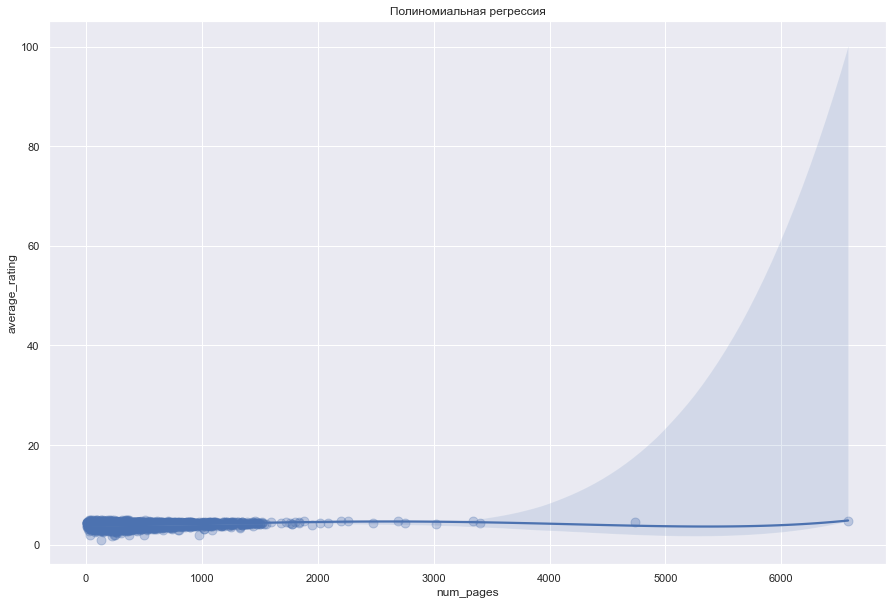

In [9]:
# полиномиальная регрессия
fig, ax = plt.subplots(figsize=(15, 10)) 
sns.regplot(x='num_pages', y='average_rating', data=db, scatter_kws={'s':80, 'alpha': 0.3}, order=4)
plt.title('Полиномиальная регрессия')

Text(0.5, 1.0, 'Линейная регрессия с третьим признаком')

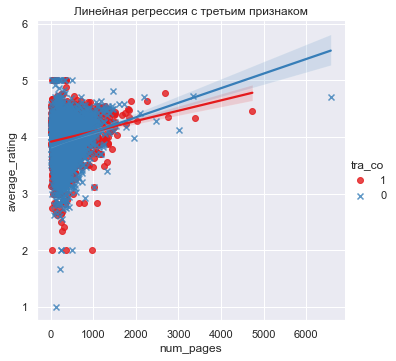

In [10]:
# линейная регрессия с третьим признаком, 
# который задан цветом
sns.lmplot(x='num_pages', y='average_rating', hue="tra_co", data=db, markers=["o", "x"], palette="Set1")
plt.title('Линейная регрессия с третьим признаком')

Дополнительно про возможные типы фигур на графиках см. в [1.3.3.26.1.
Scatter Plot: No Relationship](https://www.itl.nist.gov/div898/handbook/eda/section3/eda33q1.htm) и далее.


# Статистический подход

В данном разделе будет использована библиотека statsmodels. Данная библиотека дает широкий вывод оценок модели, что позволяет проверить допущения линейной регрессии. Также будет возможность удалить выбросы.

# Проверка условий для применения линейной регрессии

Условия применения линейной регрессии описаны выше. Часть таких условий проверяется до проведения обучения, а часть - после. В этом разделе рассмотрены те условия, которые проверяются до проведения обучения.

In [11]:
# проверка на нормальное распределение переменных 
# и зависимой переменной
feature = ['average_rating', 'num_pages', 'ratings_count','text_reviews_count', 'len_title', 'polarity', 'subjectivity']


"""
Function for Shapiro test for multiple variables
"""
def shapiro(x):
    df = pg.normality(db[x])
    return df
    
data_intermediate = [{'Нормальное распределение': shapiro(i)['normal'][0]} for i in feature]

data_norm = pd.DataFrame(data_intermediate, index=['average_rating', 'num_pages', 'ratings_count',
                        'text_reviews_count', 'len_title', 'polarity', 'subjectivity'])

data_norm

C:\Users\runaz\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\runaz\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\runaz\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\runaz\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\runaz\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\runaz\anaconda3\lib\site-packages\scipy\s

,Нормальное распределение
average_rating,False
num_pages,False
ratings_count,False
text_reviews_count,False
len_title,False
polarity,False
subjectivity,False


Тест показывает, что переменные не подчиняются нормальному распределению. Однако здесь надо учитывать два момента. Как указывалось выше, если есть большая выборка, то можно полагать, что данные все-таки подчинены нормальному распределению, даже если формальные тесты этого не показывают. В моих данных более 10 тыс. наблюдений, поэтому можно применить указанный принцип. Кроме того, как указывалось выше, в некоторых руководствах утверждается, что нормальность распределения и вовсе не является условием применения линейной регрессии.

Если данные не соответствуют нормальному распределению, то их можно попытаться преобразовать. Например, можно преобразовать данные к логарифму. Ниже показан пример этого. Однако здесь я делать этого не буду. Во-первых, это усложняет интерпретацию. Если преобразовать данные, то и модель линейной регрессии получится на таких преобразованных значениях. Это означает, что реальные данные, которые будут использоваться уже после построения модели, также потребуется сначала преобразовывать. Во-вторых, учитывая, что нормальность распределения особо не важна (см. выше), будет неэффективным, если потратить вычислительные ресурсы на преобразование.

In [12]:
# пример преобразования данных к нормальному распределению
a = 0.001 
num_pages_log = np.log(db['num_pages'] + a) 
num_pages_log.skew()

-0.8575766935290924

# Обнаружение выбросов

В этой части исследуются данные на выбросы, а далее проводится масштабирование. Есть несколько близких по смыслу определений выбросов. Приведу примеры.

Выбросы можно определить как такие элементы набора данных, которые не были получены в результате процессов, породивших этот набор данных. Например, рассмотрю количество страниц в книгах. Значение в 300 страниц вполне можно считать таким значением, которе является естественным для книг. А вот значение в 1 млн страниц - нет. 1 млн - это, скорее, остаток на счете богатого человека.

Выбросы могут также быть получены как результат ошибки. Например, если будет указано в средней оценке 45.7, то, возможно, речь на самом деле идет об оценке 4.57.

От выбросов надо отличать шум в данных. Например, если магазин устраивает распродажу, то показатели по отдельным категориям товаров могут быть значительно выше остальных периодов. Однако это не является выбросом.

Важно учитывать, что обнаружение выбросов отличается для одномерных и многомерных данных. В качестве примера начну с одномерных данных, а затем перейду к многомерным. Общий подход заключается в том, что выбросы определяются в сравнении с известным распределением, как правило нормальным. При этом сначала определяются влиятельные наблюдения. Потому как, если наблюдение не влияет на линию регрессии, то выброс это или нет уже неважно. Дальше, если удалось найти влиятельные точки, то уже эти точки проверяются на отнесение к выбросам. 

При обработке выбросов надо учитывать, что возможна маскировка выбросов, когда отдельные, слишком большие выбросы маскируют выбросы с меньшимими значениями.

Что делать при обнаружении выбросов?

1) если достоверно известно, что выбросы являются технической ошибкой, то такое значение надо скорректировать (если известно истинное значение), либо удалить;

2) если объяснить причину появления выбросов нельзя, тогда удалять или корректировать выбросы не рекомендуется, однако необходимо применяет робастные тесты и методы машинного обучения. Однако, на практике, выбросы чаще всего именно удаляют;

3) альтернативой является проведение анализа дважды - при наличии выбросов и без выбросов.

Ответы на вопросы по обнаружению выбросов можно найти на следующих ресурсах:

1) [Introduction to Anomaly Detection in Python](https://blog.floydhub.com/introduction-to-anomaly-detection-in-python/)

2) [Detection of Outliers](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm)

3) [Anomaly Detection Learning Resources](https://github.com/yzhao062/anomaly-detection-resources)

In [13]:
db_stat = db.copy()
db_stat.describe()

,average_rating,num_pages,ratings_count,text_reviews_count,len_title,polarity,subjectivity
count,10838.000000,10838.000000,1.083800e+04,10838.000000,10838.000000,10838.000000,10838.000000
mean,3.942158,344.175217,1.834788e+04,553.074737,30.258719,0.031306,0.149035
std,0.295387,238.556381,1.138660e+05,2599.330244,22.938807,0.193648,0.270061
min,1.000000,11.000000,0.000000e+00,0.000000,2.000000,-1.000000,0.000000
25%,3.770000,203.000000,1.170000e+02,10.000000,15.000000,0.000000,0.000000
50%,3.960000,304.000000,8.035000e+02,49.000000,22.000000,0.000000,0.000000
75%,4.130000,417.000000,5.226750e+03,248.000000,39.000000,0.000000,0.250000
max,5.000000,6576.000000,4.597666e+06,94265.000000,254.000000,1.000000,1.000000


Заподозрить наличие выбросов можно еще на стадии знакомства с данными. В приведенной таблице видно, например, что максимальное количество страниц равно 6576 при среднем 344. Однако надо учитывать, что выбросы - это именно ошибочные данные. Можно ли считать, что значение в 6576 страниц является ошибкой для данных? Разве нельзя представить, что есть книга с таким количеством страниц? Можно. В такой ситуации, в принципе, можно дальше и не искать выбросы. 

Важно учитывать также следующее. При обнаружении выбросов интерес представляют не сами по себе значения, ведь нормальность распределения определяется не только такими значениями, но и плотность распределения значений.

К вопросу о выбросах можно подойти и более формально. В конечном счете, как нет оснований считать количество страниц просто шумом (какой-то писатель решил написать самую толстую в мире книгу), так и нет оснований полагать, что какому-то писателю это пришло в голову. Поэтому формальная проверка на выбросы будет вполне оправданной. При этом надо помнить, что в любом случае не рекомендуется удалять более 20% данных при анализе выбросов. Следовательно, если получу значение ниже этого, то ничто не помешает пометить такие данные как выбросы. 

# Одномерные данные

Начну с одномерных данных, чтобы лучше разобраться, что такое выбросы. Сначала использую визуальный метод обнаружения выбросов. Затем использую математический метод, при этом воспользуюсь собственной библиотекой papanda.

<AxesSubplot:xlabel='num_pages'>

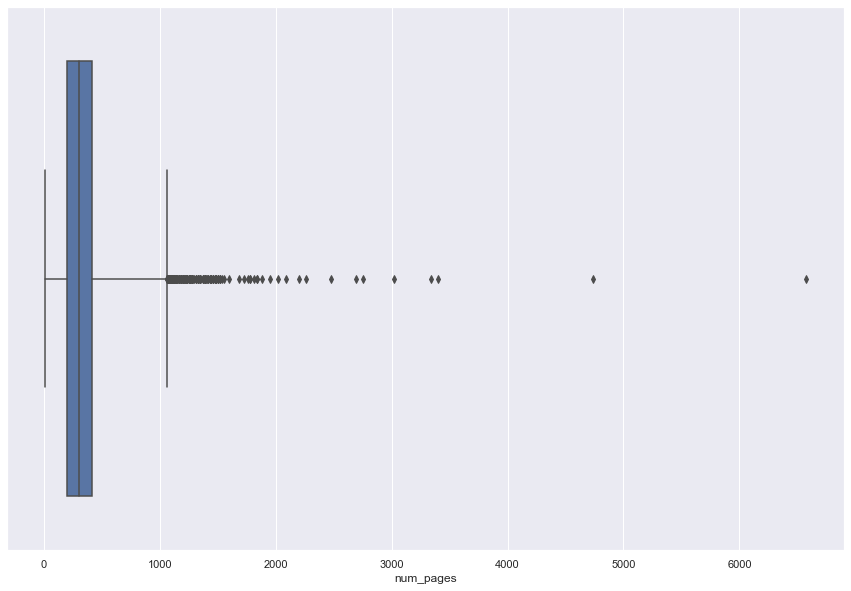

In [14]:
ig, ax = plt.subplots(figsize=[15, 10])

# whis задает межквартильный размах, за границами которого наблюдения 
# квалифицируются как выбросы
sns.boxplot(x=db_stat['num_pages'], fliersize=5, whis=3) 

Для ящика с усами прмиеняется такое правило: если наблюдения находятся за границей 1,5 межквартильного размаха, то это предполагаемые выбросы, а дальше 3 - однозначные выбросы. Здесь видно, что выбросы начинаются в районе 1100 страниц. Можно уточнить это значение с помощью теста GESD из библиотеки papanda.

In [15]:
num = list(db_stat['num_pages'])
gesd.GESD(num, 0.05, 100)

    number_of_outliers   r-stat  l-critical index_of_outliers
0                    0  26.1231    4.577102              6576
1                    1  19.0202    4.577083              4736
2                    2  13.4628    4.577063              3400
3                    3  13.3199    4.577044              3342
4                    4  11.9890    4.577024              3020
..                 ...      ...         ...               ...
95                  95   4.6094    4.575246              1227
96                  96   4.5884    4.575226              1222
97                  97   4.5622    4.575207       Not outlier
98                  98   4.5622    4.575207       Not outlier
99                  99   4.5622    4.575207       Not outlier

[100 rows x 4 columns]


Видно, что 1222 страниц - это выбросы, а вот ниже - уже к выбросам не относится. Далее можно удалить из переменной **num_pages** выбросы и посмотреть статистики этой переменной, очищенного от выбросов. Здесь я этого делать не буду, главное, чтобы был понятен общий принцип. Подробнее с библиотекой papanda можно ознакомиться на [GitHub](https://github.com/Ruslan-Nazarov/papanda). Ниже приведены дополнительные замечания, которые носят справочный характер. 

Тест GESD является версией теста Грабса, но отличие состоит в том, что тест применяется итеративно. Можно применить тест Грабса к одному наблюдению, определить относится ли оно к выбросам. Затем перейти к следующему и т.д. Алгоритм заключается в том, чтобы:

1) определить контрольную статистику; 
2) вычислить критическое значение. 

Изначально надо выбрать предполагаемое количество выбросов. Вижу, что точек, которые сильно отрываются от остальных данных, две. Но допускается взять большее количество, поэтому возьмем 100. Рекомендуется устанавливать выбросы не более 20%.

Далее вижу, что 1216 страниц уже не являются выбросами. Все, что выше этого значения, является выбросами. Этот результат аналогичен тому, который получается по графику ящик с усами.

Предыдущая проверка исходила из того, что данные подчинены нормальному распределению. Теперь предположу, что это другое распределение. В случае с экспоненциальным распределением можно использовать статистику Гринвуда. Если же распределение отличается от нормального и экспоненциального, то надо преобразовать его к нормальному, а затем воспользоваться указанным выше тестом GEDS.

Если данные из логнормального распределения, то натуральный логарифм приводит их к нормальному распределению. Если данные из распределения экстремальных значений типа 1, то применение экпоненты приводит их к экспоненциальному распределению. Аналогично, если данные из распределения Вейбулла, то специальное преобразование приводит данные к экспоненциальному распределению. Для гамма-распределений применение кубического корня приводит к нормальному распределению.

Если преобразование неизвестно, то нужно привести данные к нормальному распределению с помощью Бокса-Кокса (только положительные значения в данных) или преобразования Джонсона (может применяться с отрицательными значениями в данных).

# Многомерные данные

Обнаружить выбросы в многомерных данных сложнее. Многомерный выброс - это выброс по любой из компонент наблюдения или многомерных координат. Общий подход заключается в том, что многомерный набор данных преобразуется к одномерным статистикам. Для оценки применяется расстояние Махаланобиса. 

Влиятельные наблюдения определяются через DFFITS и расстояние Кука. В случае обнаружения выбросов может быть применена робастная регрессионная модель, получаемая методом усеченных наименьших квадратов. 

Хорошее описание проблемы выбросов [здесь](https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/).

При этом необходимо учитывать следующее. Если обнаружение выбросов осуществляется в рамках статистического исследования, то это осуществляется на всем наборе данных. Если же обнаружение выбросов необходимо в рамках машинного обучения, то:

1) либо обнаружение выбросов осуществляется только на тренировочном наборе, выбросы удаляются, модель обучается на тренировочных данных без выбросов, а затем тестируется; 
2) либо обнаружение выбросов осуществляется на тренировочном наборе, для чего обучается специальная модель, а затем обученная модель вносит изменения в тренировочные и тестовые данные (на тестовых данных модель нельзя обучать).

In [16]:
a = db_stat[['num_pages', 'ratings_count', 'text_reviews_count', 'len_title', 'polarity', 'subjectivity']] 
a_const= sm.add_constant(a, prepend=False)
model = sm.OLS(db_stat['average_rating'], a_const) 
results = model.fit() 
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         average_rating   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     81.40
Date:                Fri, 01 Apr 2022   Prob (F-statistic):          5.03e-100
Time:                        10:56:58   Log-Likelihood:                -1922.3
No. Observations:               10838   AIC:                             3859.
Df Residuals:                   10831   BIC:                             3910.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
num_pages              0.0002   1.17

Мультиколинеарность есть из-за высокой корреляции между числом оценок и числом обзоров.

Из учебника Дэвидсона: "При выборе модели не существует четкого различия между статистиками AIC и BIC. В качестве критерия выбора статистика BIC является асимптотически состоятельной. Это означает, что при заданном семействе моделей, включая истинную модель, вероятность того, что статистика BIC выберет правильную модель, стремится к единице, когда размер выборки N стремится к бесконечности. Это не относится к статистике AIC, которая склонна выбирать слишком сложные модели, когда N стремится к бесконечности. С другой стороны, для конечных выборок статистика BIC часто выбирает модели, которые являются слишком простыми из-за большего штрафа за сложность... 

Однако для многих адаптивных, нелинейных методов (например, деревьев) оценка эффективного количества параметров очень сложная. Это делает такие методы, как AIC, непрактичными и оставляет нам перекрестную проверку или бутстрэп в качестве методов выбора".

In [17]:
# влиятельные наблюдения
influence = results.get_influence() 

# общее описание влиятельных наблюдений
pd.Series(influence.hat_matrix_diag).describe() 

count    10838.000000
mean         0.000646
std          0.003318
min          0.000101
25%          0.000172
50%          0.000240
75%          0.000496
max          0.192814
dtype: float64

In [18]:
# табличное представление
inf_sum = influence.summary_frame() 
print(inf_sum.head(10))

   dfb_num_pages  dfb_ratings_count  dfb_text_reviews_count  dfb_len_title  \
0       0.009225           0.208361               -0.121834       0.011115   
1       0.010834           0.117202               -0.066370       0.007889   
2      -0.000051          -0.000250               -0.000443       0.008973   
3      -0.002347           0.192170               -0.088000       0.016550   
4       0.109983           0.006762               -0.008425      -0.000589   
5       0.007051          -0.000260                0.000313      -0.020415   
6       0.068380          -0.000383               -0.000571      -0.003175   
7       0.019448          -0.000508                0.000030       0.010792   
8       0.020057           0.017347               -0.008520      -0.000651   
9      -0.005678          -0.001788                0.001585       0.004676   

   dfb_polarity  dfb_subjectivity  dfb_const   cooks_d  standard_resid  \
0     -0.010861          0.005218  -0.015335  0.008238        1.148

В этой таблице:

**cooks_d** - расстояние Кука

**standard_resid** - стандартизированные остатки

**hat_diag** - кредитное плечо, то есть влияние конкретного значения на регрессионную кривую

**dffits_internal**

**student_resid** - остатки по Стьюденту

**dffits** - различие приближений

Объеденю исходный датасет и полученную выше таблицу.

См. [также](https://www.datasklr.com/ols-least-squares-regression/diagnostics-for-leverage-and-influence?rq=outliers).

In [19]:
db_stat_inf = pd.concat([db_stat, inf_sum], axis=1)
db_stat_inf = db_stat_inf.rename(columns={'hat_diag': 'leverage'})
db_stat_inf.head()

,average_rating,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume,len_title,polarity,...,dfb_len_title,dfb_polarity,dfb_subjectivity,dfb_const,cooks_d,standard_resid,leverage,dffits_internal,student_resid,dffits
0,4.57,652,2095690,27591,2000,3,1,1,39,-0.166667,...,0.011115,-0.010861,0.005218,-0.015335,0.008238,1.148201,0.041907,0.240137,1.148218,0.240140
1,4.49,870,2153167,29221,2000,3,1,1,42,0.000000,...,0.007889,0.000916,-0.002959,-0.012689,0.002705,0.648737,0.043059,0.137613,0.648720,0.137610
2,4.42,352,6333,244,2000,4,0,1,40,0.000000,...,0.008973,-0.000445,-0.010016,0.004291,0.000056,1.604048,0.000153,0.019853,1.604164,0.019854
3,4.56,435,2339585,36325,2000,2,1,1,41,0.000000,...,0.016550,0.001690,-0.006438,-0.013099,0.008824,1.154355,0.044302,0.248537,1.154373,0.248541
4,4.78,2690,41428,164,2000,3,1,1,34,0.000000,...,-0.000589,0.001725,-0.002549,-0.065316,0.001761,1.160272,0.009075,0.111034,1.160291,0.111036


Теперь надо найти пересечение предполагаемых выбросов и значений с высоким значением плеча, то есть влияния на модель регрессии.

In [20]:
outlier_lev = db_stat_inf[(db_stat_inf['leverage'].abs() > ((2*6)+2)/10838) & (db_stat_inf['student_resid'].abs() > 2)]

Вот что это означает. 

(db_stat_inf['student_resid'].abs() > 2) - это предполагаемые выбросы по целевому признаку

(db_stat_inf['leverage'].abs() > ((2*6)+2)/10838) - это предполагаемые выбросы по признакам

In [21]:
# выбросы по целевому признаку (или Y)
db_stat_inf[db_stat_inf['student_resid'].abs() > 2]

,average_rating,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume,len_title,polarity,...,dfb_len_title,dfb_polarity,dfb_subjectivity,dfb_const,cooks_d,standard_resid,leverage,dffits_internal,student_resid,dffits
24,4.53,218,19822,46,2000,4,1,0,42,0.000000,...,0.013622,-0.000885,-0.013621,0.012078,0.000126,2.068010,0.000207,0.029731,2.068323,0.029736
58,3.25,192,55,5,2000,4,0,0,39,0.000000,...,-0.012363,0.000867,0.014749,-0.016596,0.000148,-2.320277,0.000192,-0.032185,-2.320747,-0.032191
70,4.59,192,26153,102,2000,2,0,0,60,0.000000,...,0.031962,-0.001964,-0.018672,0.005065,0.000271,2.206957,0.000390,0.043575,2.207351,0.043583
74,3.34,205,174,16,2000,2,0,0,62,0.000000,...,-0.032641,0.001989,0.018501,-0.003045,0.000254,-2.127810,0.000393,-0.042173,-2.128156,-0.042180
94,2.99,360,411,65,2000,1,0,0,25,0.000000,...,0.003286,-0.000301,0.015364,-0.019854,0.000192,-3.276350,0.000125,-0.036653,-3.277824,-0.036669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10708,3.16,96,29,2,1990,4,0,0,51,0.000000,...,-0.028021,0.001932,0.020226,-0.017874,0.000335,-2.618656,0.000342,-0.048425,-2.619365,-0.048438
10715,3.39,718,13716,393,2000,3,0,1,12,0.000000,...,0.014917,-0.001419,0.005988,0.000579,0.000248,-2.097728,0.000394,-0.041627,-2.098058,-0.041633
10790,3.14,64,7,1,1990,4,0,0,11,0.000000,...,0.016560,-0.000574,0.009087,-0.042089,0.000263,-2.474493,0.000300,-0.042866,-2.475078,-0.042876
10807,3.29,482,14,2,2000,1,0,0,20,0.255682,...,0.022549,-0.015907,-0.037544,-0.003277,0.000423,-2.304750,0.000557,-0.054408,-2.305209,-0.054419


In [22]:
y_out = db_stat_inf[db_stat_inf['student_resid'].abs() > 2]
y_out

,average_rating,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume,len_title,polarity,...,dfb_len_title,dfb_polarity,dfb_subjectivity,dfb_const,cooks_d,standard_resid,leverage,dffits_internal,student_resid,dffits
24,4.53,218,19822,46,2000,4,1,0,42,0.000000,...,0.013622,-0.000885,-0.013621,0.012078,0.000126,2.068010,0.000207,0.029731,2.068323,0.029736
58,3.25,192,55,5,2000,4,0,0,39,0.000000,...,-0.012363,0.000867,0.014749,-0.016596,0.000148,-2.320277,0.000192,-0.032185,-2.320747,-0.032191
70,4.59,192,26153,102,2000,2,0,0,60,0.000000,...,0.031962,-0.001964,-0.018672,0.005065,0.000271,2.206957,0.000390,0.043575,2.207351,0.043583
74,3.34,205,174,16,2000,2,0,0,62,0.000000,...,-0.032641,0.001989,0.018501,-0.003045,0.000254,-2.127810,0.000393,-0.042173,-2.128156,-0.042180
94,2.99,360,411,65,2000,1,0,0,25,0.000000,...,0.003286,-0.000301,0.015364,-0.019854,0.000192,-3.276350,0.000125,-0.036653,-3.277824,-0.036669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10708,3.16,96,29,2,1990,4,0,0,51,0.000000,...,-0.028021,0.001932,0.020226,-0.017874,0.000335,-2.618656,0.000342,-0.048425,-2.619365,-0.048438
10715,3.39,718,13716,393,2000,3,0,1,12,0.000000,...,0.014917,-0.001419,0.005988,0.000579,0.000248,-2.097728,0.000394,-0.041627,-2.098058,-0.041633
10790,3.14,64,7,1,1990,4,0,0,11,0.000000,...,0.016560,-0.000574,0.009087,-0.042089,0.000263,-2.474493,0.000300,-0.042866,-2.475078,-0.042876
10807,3.29,482,14,2,2000,1,0,0,20,0.255682,...,0.022549,-0.015907,-0.037544,-0.003277,0.000423,-2.304750,0.000557,-0.054408,-2.305209,-0.054419


In [23]:
# растояние Кука
cutoff=(db_stat_inf.loc[:,"cooks_d"].mean())*3
cutoff

0.00034190977483836854

In [24]:
outlier1 = y_out[abs(y_out["cooks_d"]) > cutoff]
print(outlier1)

       average_rating  num_pages  ratings_count  text_reviews_count decade  \
244              3.09        571           1601                 284   2000   
498              2.80         80              5                   0   1980   
516              2.83        664              0                   0   2000   
517              3.50        854              0                   0   2000   
564              2.67        196              9                   2   2000   
...               ...        ...            ...                 ...    ...   
10657            3.20        240            207                  28   2000   
10660            4.70        712            404                  30   1980   
10663            4.67         29              3                   0   2000   
10807            3.29        482             14                   2   2000   
10808            2.33        272              3                   0   2000   

      quarter tra_co multivolume  len_title  polarity  ...  dfb

In [25]:
# выбросы по признакам (или X)
x_out = db_stat_inf[db_stat_inf['leverage'].abs() > ((2*6) + 2)/10838]
x_out

,average_rating,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume,len_title,polarity,...,dfb_len_title,dfb_polarity,dfb_subjectivity,dfb_const,cooks_d,standard_resid,leverage,dffits_internal,student_resid,dffits
0,4.57,652,2095690,27591,2000,3,1,1,39,-0.166667,...,0.011115,-0.010861,0.005218,-0.015335,0.008238,1.148201,0.041907,0.240137,1.148218,0.240140
1,4.49,870,2153167,29221,2000,3,1,1,42,0.000000,...,0.007889,0.000916,-0.002959,-0.012689,0.002705,0.648737,0.043059,0.137613,0.648720,0.137610
3,4.56,435,2339585,36325,2000,2,1,1,41,0.000000,...,0.016550,0.001690,-0.006438,-0.013099,0.008824,1.154355,0.044302,0.248537,1.154373,0.248541
4,4.78,2690,41428,164,2000,3,1,1,34,0.000000,...,-0.000589,0.001725,-0.002549,-0.065316,0.001761,1.160272,0.009075,0.111034,1.160291,0.111036
6,4.73,3342,28242,808,2000,3,0,1,24,0.000000,...,-0.003175,0.001249,-0.000192,-0.040173,0.000674,0.562016,0.014709,0.068669,0.561998,0.068667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10774,4.27,158,839,65,2000,3,0,1,98,0.800000,...,0.024328,0.034074,-0.014877,-0.005286,0.000283,0.902376,0.002424,0.044479,0.902368,0.044479
10775,4.34,175,675,61,2000,1,0,1,113,0.066667,...,0.039547,-0.001199,-0.007372,-0.011938,0.000250,1.114341,0.001405,0.041792,1.114353,0.041792
10780,4.00,112,1,0,2000,3,1,0,84,0.800000,...,0.001238,0.002666,0.001418,-0.000469,0.000003,0.090549,0.002181,0.004233,0.090545,0.004233
10787,3.76,101,328,43,2000,2,1,0,36,-1.000000,...,0.000712,0.023770,-0.017601,-0.001605,0.000103,-0.374593,0.005124,-0.026882,-0.374578,-0.026881


In [26]:
outlier2 = x_out[abs(x_out["cooks_d"]) > cutoff]
print(outlier2)

       average_rating  num_pages  ratings_count  text_reviews_count decade  \
0                4.57        652        2095690               27591   2000   
1                4.49        870        2153167               29221   2000   
3                4.56        435        2339585               36325   2000   
4                4.78       2690          41428                 164   2000   
6                4.73       3342          28242                 808   2000   
...               ...        ...            ...                 ...    ...   
10586            4.43        304            413                   5   2000   
10610            4.35        681           2276                 170   1990   
10632            4.34       3400              6                   1   1980   
10636            3.58        320            241                  30   2000   
10720            3.60        400           2777                 119   2000   

      quarter tra_co multivolume  len_title  polarity  ...  dfb

Итак, получено два набора данных - с выбросами по зависимой переменной и с выбросами по независимым переменным. Удалю выбросы и построю линейную регрессию.

In [27]:
db_stat = db_stat.drop(outlier2.index)
db_stat

,average_rating,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume,len_title,polarity,subjectivity
2,4.42,352,6333,244,2000,4,0,1,40,0.000000,0.000000
5,3.74,152,19,1,2000,2,0,0,87,-0.166667,0.166667
7,4.38,815,3628,254,2000,4,0,1,68,0.050000,0.700000
8,4.38,815,249558,4080,2000,2,0,1,46,0.000000,1.000000
9,4.22,215,4930,460,2000,3,0,1,37,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
10833,4.06,512,156,20,2000,4,1,1,48,0.000000,0.000000
10834,4.08,635,783,56,1980,4,0,0,27,0.700000,0.800000
10835,3.96,415,820,95,1990,3,0,1,14,0.000000,0.000000
10836,3.72,434,769,139,2000,1,0,0,11,-0.400000,0.600000


# Масштабирование данных

In [28]:
# список количественных признаков
col_names = ['num_pages', 'ratings_count', 'text_reviews_count', 'len_title', 'polarity', 'subjectivity'] 

# датафрейм с количественными признаками
features = db_stat[col_names] 

# вызываю и обучаю шкалировщик
scaler = StandardScaler().fit(features.values) 

# преобразую данные
features = scaler.transform(features.values) 

# применяю результаты
db_stat[col_names] = features

In [29]:
# данные после масштабирования
db_stat.head(3)

,average_rating,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume,len_title,polarity,subjectivity
2,4.42,0.058897,-0.114100,-0.128726,2000,4,0,1,0.463128,-0.159079,-0.540469
5,3.74,-0.882438,-0.212215,-0.279567,2000,2,0,0,2.603106,-1.087512,0.095796
7,4.38,2.238087,-0.156134,-0.122518,2000,4,0,1,1.738008,0.119451,2.131843


In [30]:
db_stat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10606 entries, 2 to 10837
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   average_rating      10606 non-null  float64
 1   num_pages           10606 non-null  float64
 2   ratings_count       10606 non-null  float64
 3   text_reviews_count  10606 non-null  float64
 4   decade              10606 non-null  object 
 5   quarter             10606 non-null  object 
 6   tra_co              10606 non-null  object 
 7   multivolume         10606 non-null  object 
 8   len_title           10606 non-null  float64
 9   polarity            10606 non-null  float64
 10  subjectivity        10606 non-null  float64
dtypes: float64(7), object(4)
memory usage: 994.3+ KB


# Простая линейная регрессия

In [31]:
# линейная регрессия с одним признаком
a = db_stat['num_pages'] 
a_const= sm.add_constant(a, prepend=False)
model = sm.OLS(db_stat['average_rating'], a_const) 
results = model.fit() 
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         average_rating   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     284.5
Date:                Fri, 01 Apr 2022   Prob (F-statistic):           5.09e-63
Time:                        10:57:42   Log-Likelihood:                -1748.5
No. Observations:               10606   AIC:                             3501.
Df Residuals:                   10604   BIC:                             3516.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
num_pages      0.0467      0.003     16.868      0.0

Объясню каждый элемент. Начну с верхнего левого прямоугольника.

**Dep. Variable** - целевой признак, в нашем случае это average_rating;

**Model** - это применяемая нами модель;

**Method** - это метод построения линейной регрессии;

**Date**, **Time** - время создания модели;

**No. Observation** - это количество элементов (строк, наблюдений) в данных;

**Df Residuals** - это остатки;

**R-squared** - это коэффициент детерминации, то есть количество дисперсии, которая объясняется нашей моделью. В данном случае у нас это 0.030. Этот коэффициент представляет собой квадрат коэффициента корреляции между реальными и предсказанными значениями;

**Adj. R-squared** -  тоже самое, но с учетом специальной поправки;

**F-statistic** - позволяет ответить на вопрос: лучше ли наша модель, чем модель, в которой все коэффициенты равны 0. Наша F-статистика равна 3 при p-value < 0.05, то есть нулевую гипотезу о случайности мы можем отвергнуть; 

**Prob (F-statistic)** - вероятность получить значение случайно, у нас низкая. Это означает следующее: если вероятность ниже альфа-уровня, например 0.05, то наша модель лучше предсказывает целевой признак, чем модель, в которой все коэффициенты равны нулю. Обратно: если вероятность выше 0.05, то наша модель хуже предсказывает целевой признак, чем модель, в которой все коэффициенты равны нулю;

**coef** - это коэффициент в формуле линейной регрессии, на который умножается значение признака, коэффициент наклона. У нас это 0.0002, то есть коэффициент незначим, мы можем предсказать значения просто по точке пересечения;

**std err** - это то, насколько фактические значения отличаются от регрессионной прямой. Другими словами, это усредненная ошибка предсказания оценки книги по количеству страниц;

**t** - статистика показывает важность переменных в модели и получается в результате деления регрессионного коэффициента для признака на стандартную ошибку коэффициента. Чем выше t статистика и ниже p-значение, тем более значим признак;

**P>|t|** - вероятность получить значение случайно;

**[0.025      0.975]** - доверительные интервалы для коэффициента.

Нижняя часть вывода - это проверка на соблюдение условий для применения линейной регрессии. Здесь обследуются остатки. Если условия по остаткам не выполняются, то мы не можем принять результаты линейной регрессии.

**Omnibus** - это тест на нормальное распределение остатков. Вероястность (Prob(Omnibus)) должна стремиться к 1, чтобы мы могли сказать, что остатки распределены нормально. В нашем случае это не выполняется. 

**Skew** - это перекос графика распределения остатков. В идеале перекоса не должно быть, а значит значение должно быть 0. У нас это не так, есть левосторонний перекос.

**Kurtosis** - это показатель "остроты" пика графика распределения остатков. 

**Durbin-Watson** - тест на гомоскедастичность остатков, статистика может принимать значения от 0 до 4, значение 2 показывает независимость остатков. У нас значение 1.517

**Jarque-Bera** это еще один тест на нормальность. 

**Cond. No.** - тест на мультиколлинеарность. 

In [32]:
# линейная регрессия с двумя признаками
X = db_stat[['num_pages', 'ratings_count']]
y = db_stat['average_rating']
X = sm.add_constant(X)
model_mult = sm.OLS(y, X)
results2 = model_mult.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:         average_rating   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     152.9
Date:                Fri, 01 Apr 2022   Prob (F-statistic):           3.37e-66
Time:                        10:57:42   Log-Likelihood:                -1738.1
No. Observations:               10606   AIC:                             3482.
Df Residuals:                   10603   BIC:                             3504.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.9421      0.003   1423.998

Это пример множественной линейной регрессии. 

Здесь важно отсутствие мультиколлинеарности. Это можно проверить с помощью коэффициентов корреляции, а можно использовать Variance Inflation Factor, если дано 3 и более признака. Здесь я воспользуюсь этим методом для демонстрации.

In [33]:
x = patsy.dmatrix("num_pages + ratings_count", data = db)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x, i) for i in range(x.shape[1])]
vif["Features"] = x.design_info.term_names
vif

,VIF Factor,Features
0,3.095572,Intercept
1,1.000906,num_pages
2,1.000906,ratings_count


Первая строка в этом выводе должна быть проигнорирована. Если в других строках **VIF** больше 10, то имеется мультиколлинеарность. Однако это не так. Вывод: **ratings_count** помогает улучшить модель. Оставляю **num_pages**,  **ratings_count**.

В данном случае количественные признаки не ограничиваются только количеством страниц и количеством оценок. Есть также следующие признаки: **text_reviews_count**, **len_title**, **polarity**, **subjectivity**. Если дано более одного признака, то встает вопрос о стратегии обучения. Здесь возможно:

1) добавить все признаки сразу, затем удалять по одному и смотреть, как изменяются метрики;
2) добавлять признаки по одному и смотреть, как изменяются метрики.

Воспользуюсь первой стратегией.

In [34]:
X = db_stat[['num_pages', 'text_reviews_count', 'ratings_count', 'len_title', 'polarity', 'subjectivity']]
y = db_stat['average_rating']
X = sm.add_constant(X)
model_mult = sm.OLS(y, X)
results2 = model_mult.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:         average_rating   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     82.18
Date:                Fri, 01 Apr 2022   Prob (F-statistic):          6.21e-101
Time:                        10:57:42   Log-Likelihood:                -1647.8
No. Observations:               10606   AIC:                             3310.
Df Residuals:                   10599   BIC:                             3361.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  3.9421      0

Интересно, что в лучшей модели **text_reviews_count** имеет отрицательный коэффициент. Здесь можно выдвинуть предположение, что увеличение количества отзывов уменьшает оценку. 

In [35]:
# линейная регрессия с категориальным признаком
sm.OLS.from_formula
mod = smf.ols('average_rating ~ C(decade)', data=db_stat) 
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         average_rating   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.078
Date:                Fri, 01 Apr 2022   Prob (F-statistic):            0.00306
Time:                        10:57:42   Log-Likelihood:                -1878.2
No. Observations:               10606   AIC:                             3772.
Df Residuals:                   10598   BIC:                             3831.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.9736      0.06

In [36]:
# линейная регрессия с взаимодействием между признаками
mod = smf.ols('average_rating ~ len_title*num_pages', data=db_stat) 
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         average_rating   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     152.4
Date:                Fri, 01 Apr 2022   Prob (F-statistic):           1.02e-96
Time:                        10:57:43   Log-Likelihood:                -1665.0
No. Observations:               10606   AIC:                             3338.
Df Residuals:                   10602   BIC:                             3367.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               3.9421    

# Машинное обучение

Чтобы применить машинное обучение, надо ответить на несколько вопросов.

1) Какую модель выбрать? В этой главе я использую линейную регрессию (возможно также применение робастной линейной регрессии, полиномиальной, а также применение регуляризации).

2) Требуется ли дополнительная подготовка данных для выбранной модели? Например, можно добавить дополнительные признаки в ручном режиме или автоматически. Необходимо также масштабировать данные.

3) Какие параметры модели надо настраивать и как? Буду использоват решетчатый поиск с кросс-валидацией.

4) Что будет оценкой качества модели? MSE и R2.

5) Как можно получить предсказания по новым данным?

Порядок действий такой: 

1) задаю модель линейной регрессии; 

2) разделяю данные на тренировочный и тестовый наборы. Разделить данные можно в следующих пропорциях 80:20, 60:40 или 70:30; 

3) подготавливаю данные (возможно с применением метода Pipeline); 

4) тренирую модель с настройкой параметров и оценкой; 

5) выбираю лучшую модель; 

6) провожу проверку на тестовом наборе; 

7) применяю для новых данных.

Важно помнить следующие два обстоятельства: 

1) всегда надо стремиться найти самую простую и эффективную модель. Поэтому начинать стоит с базовой. 

2) при подготовке данных для машинного обучения, можно добавлять признаки, очищать их, модифицировать до разделения на тренировочный и тестовый набор или после. До разделения можно применять только нематематические методы, которым не требуются расчеты на всем датафрейме. Все математические методы, которые требуют расчетов, надо применять только после разделения на тренировочный и тестовый наборы, причем только на тренировочном (с последующим применением результатов и к тестовому).

Важно помнить, что надо удалить выбросы и масштабировать данные. Выбросы удалю иначе, чем это было сделано в разделе Статистический анализ. 

Здесь надо отдельно подчеркнуть, что желательно давать подробное наименование для переменных.

In [37]:
# независимые переменные
X = db.drop('average_rating', axis = 1)

# зависимая переменная
y = db['average_rating']

In [38]:
# разбиваю данные на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6)

# Подготовка данных 

Заполнение пропусков здесь приводится для примера, так как в изначальных данных пропусков нет.

In [39]:
"""

# все нижеследующее надо проводить только на обучающем наборе

# в данных нет пропусков, но в демонстрационных целях предположу эту
# SimpleImputer - это инструмент для заполнения пропусков

imputer = SimpleImputer(strategy='median') 

# оставляю только количественные признаки

X_train_1 = X_train.select_dtypes(include=[np.number]) 

# обучаю для заполнения пропусков

imputer.fit(X_train_1) 

# заполняю пропуски и возвращаю к формату датафрейма

X_1 = imputer.transform(X_train_1) 
X_train = pd.DataFrame(X_1, columns=X_train_1.columns, index=booksX_train.index) 

"""

"\n\n# все нижеследующее надо проводить только на обучающем наборе\n\n# в данных нет пропусков, но в демонстрационных целях предположу эту\n# SimpleImputer - это инструмент для заполнения пропусков\n\nimputer = SimpleImputer(strategy='median') \n\n# оставляю только количественные признаки\n\nX_train_1 = X_train.select_dtypes(include=[np.number]) \n\n# обучаю для заполнения пропусков\n\nimputer.fit(X_train_1) \n\n# заполняю пропуски и возвращаю к формату датафрейма\n\nX_1 = imputer.transform(X_train_1) \nX_train = pd.DataFrame(X_1, columns=X_train_1.columns, index=booksX_train.index) \n\n"

Выполнить удаление выбросов можно с помощью как sklearn, так и специализированной библиотеки Pyod. Покажу оба подхода. Как и всегда, надо помнить, что fit делается только на обучающих данных. Другими словами, нельзя допускать утечку признака. Здесь удалю выбросы, хотя это и не рекомендуется делать.

In [40]:
"""
# поиск выбросов с помощью scikit-learn
# приводится для примера

from sklearn.ensemble import IsolationForest

X = db_copy.drop(['title', 'average_rating', 'language_code', 'decade', 'quarter', 'tra_co', 'multivolume'], axis=1)
y = db_copy['average_rating'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42) 

iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train)
mask = yhat != -1

X_train_c = X_train.copy()
y_train_c = y_train.copy()
X_train_c['yhat'] = yhat
X_train_c = X_train_c[mask]
y_train_c = y_train_c.loc[X_train_c.index]
X_train_c = X_train_c.drop('yhat', axis=1)

yhat1 = iso.predict(X_test)

mask = yhat1 != -1
X_test_c = X_test.copy()
y_test_c = y_test.copy()
X_test_c['yhat'] = yhat1
X_test_c = X_test_c[mask]
y_test_c = y_test_c.loc[X_test_c.index]
X_test_c = X_test_c.drop('yhat', axis=1)

"""

"\n# поиск выбросов с помощью scikit-learn\n# приводится для примера\n\nfrom sklearn.ensemble import IsolationForest\n\nX = db_copy.drop(['title', 'average_rating', 'language_code', 'decade', 'quarter', 'tra_co', 'multivolume'], axis=1)\ny = db_copy['average_rating'] \nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42) \n\niso = IsolationForest(contamination=0.1)\nyhat = iso.fit_predict(X_train)\nmask = yhat != -1\n\nX_train_c = X_train.copy()\ny_train_c = y_train.copy()\nX_train_c['yhat'] = yhat\nX_train_c = X_train_c[mask]\ny_train_c = y_train_c.loc[X_train_c.index]\nX_train_c = X_train_c.drop('yhat', axis=1)\n\nyhat1 = iso.predict(X_test)\n\nmask = yhat1 != -1\nX_test_c = X_test.copy()\ny_test_c = y_test.copy()\nX_test_c['yhat'] = yhat1\nX_test_c = X_test_c[mask]\ny_test_c = y_test_c.loc[X_test_c.index]\nX_test_c = X_test_c.drop('yhat', axis=1)\n\n"

В коде я отдельно обучил модель и применил на тренировочных данных, но для тестовых данных отдельное обучение не проводил, а только применил модель, которую ранее обучил на тренировочных данных. 

In [41]:
# использование библиотеки Pyod
clf = KNN(contamination=0.02, n_neighbors=5)
clf.fit(X_train)
out = clf.predict(X_train)
X_train['out'] = out

C:\Users\runaz\AppData\Local\Temp/ipykernel_78224/2325270777.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['out'] = out


In [42]:
out1 = clf.predict(X_test)
X_test['out'] = out1

C:\Users\runaz\AppData\Local\Temp/ipykernel_78224/2341353665.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['out'] = out1


In [43]:
# в дальнейшем обучение проводится уже на этих данных
X_train = X_train[X_train['out'] != 1]
X_test = X_test[X_test['out'] != 1]

y_train = y_train[X_train.index]
y_test = y_test[X_test.index]

In [44]:
'''

X_train = X_train.drop('out', axis = 1)
X_test = X_test.drop('out', axis = 1)

y_train = y_train.drop('out', axis = 1)
y_test = y_test.drop('out', axis = 1)
'''

"\n\nX_train = X_train.drop('out', axis = 1)\nX_test = X_test.drop('out', axis = 1)\n\ny_train = y_train.drop('out', axis = 1)\ny_test = y_test.drop('out', axis = 1)\n"

In [45]:
# масштабирование
col_names = ['num_pages', 'ratings_count', 'text_reviews_count', 'len_title', 'polarity', 'subjectivity'] 

# создаю датафрейм с количественными признаками
features = X_train[col_names] 

# вызываю и обучаю шкалировщик
scaler = StandardScaler().fit(features.values) 

# преобразую данные
features = scaler.transform(features.values) 

# применяю результаты
X_train[col_names] = features 

# применяю к тестовому набору
features_test = X_test[col_names]
features_test = scaler.transform(features_test.values) 
X_test[col_names] = features_test

В учебнике Машинное обучение утверждается следующее: "Реализация линейной регресиси из библиотеки scikit также (лучше) работает с нестандартизированными переменными, поэтому она не применяет оптимизацию на основе стохастического градиентного спуска, так что шаг стандартизации мы можем пропустить".

Перехожу к кодированию. Существует множество способов кодирования категориальных данных. Как правило, они все так или иначе связаны с частотностью появления категории. Здесь возьму самый распространенный способ.

In [46]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Подготовка данных с Pipline

Применение Pipline является распространенной практикой. Однако стоит заметить, что этот инструмент по сути скрывает трансформацию данных. Поэтому применять его можно, если есть уверенность в конечном результате применяемых инструментов. Ниже приведен код только для примера.

In [47]:
"""
# приводится для примера

# оставляю только количественные признаки
# провожу импутацию признаков и их стандартизацию

col_num = books.select_dtypes(include=[np.number]) 
num_pipline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())])

# разделяю данные на числовые и категориальные

num_atrib = list(col_num) 
cat_atrib = ['tra_co', 'decade', 'quarter', 'multivolume'] 


# обратите внимание, что применяемый инструмент можно указать непосредственно в трубе, например ohe

full_pipe = ColumnTransformer([
    ('num', num_pipline, num_atrib),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_atrib)
]) 

X_train_prepared = full_pipe.fit_transform(X_train)

"""

"\n# приводится для примера\n\n# оставляю только количественные признаки\n# провожу импутацию признаков и их стандартизацию\n\ncol_num = books.select_dtypes(include=[np.number]) \nnum_pipline = Pipeline([('imputer', SimpleImputer(strategy='median')),\n                        ('scaler', StandardScaler())])\n\n# разделяю данные на числовые и категориальные\n\nnum_atrib = list(col_num) \ncat_atrib = ['tra_co', 'decade', 'quarter', 'multivolume'] \n\n\n# обратите внимание, что применяемый инструмент можно указать непосредственно в трубе, например ohe\n\nfull_pipe = ColumnTransformer([\n    ('num', num_pipline, num_atrib),\n    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_atrib)\n]) \n\nX_train_prepared = full_pipe.fit_transform(X_train)\n\n"

# Обучение

In [48]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train) 

LinearRegression()

# Оценка

In [49]:
# оценка на тренировочных данных
some_data = X_train.iloc[:5]
some_labels = y_train.iloc[:5]

# эти оценки получит книга
print("Прогноз:", lin_reg.predict(some_data))

Прогноз: [3.92480469 3.93164062 3.90332031 3.86816406 3.95019531]


In [50]:
# а это реальные данные
print('Прогноз:', list(some_labels)) 

Прогноз: [4.15, 3.78, 4.36, 3.39, 4.06]


In [51]:
# оценка на тестовых данных
# проверка модели с помощью MSE на обучающих данных
X_predict = lin_reg.predict(X_test)
lin_mse = mean_squared_error(y_test, X_predict)
lin_mse

0.07483740874693419

Дополнительно можно также использовать коэффициент детерминации R2 для оценки модели.

Коэффициент детерминации в идеале должен быть 1. Данный коэффициент показывает, сколько процентов дисперсии может объяснить наша модель. MSE показывает ошибку между предсказанным значением и фактическим. 

In [52]:
# проверка на случайных данных
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
y_predict_dummy_mean = dummy.predict(X_train)

dummy.score(y_predict_dummy_mean, y_train) 

0.0

# Улучшение модели

Если модель работает неудовлетворительно, то ее можно дополнительно настроить. Настройка может предполагать предварительную диагностику модели. Здесь я покажу распространенные способы диагностики и настройки:

1) переменных слишком много - надо уменьшить размерность данных;
2) параметры подобраны неправильно - можно перебрать параметры и найти лучшие;
3) можно изменить размер набора данных и посмотреть, как будут меняться результаты модели.

## Уменьшение размерности данных

Большое количество независимых переменных не всегда является положительным. Например, из-за этого может возникнуть проблема, которую называют "проклятие размерности". Поэтому можно удалить часть переменных, что может значительно улучшить модель. Сделать это можно в ручном режиме или автоматически. Ниже показан пример автоматического определения самых важных переменных. 

Понижение размерности возможно либо через отбор из имеющихся переменных, лио через создание новых переменных на основе имеющихся. 

In [53]:
# рекурсивное устранение переменных
rfecv = RFECV(estimator=lin_reg, step=1, scoring='neg_mean_squared_error')
rfecv.fit(X_train, y_train)
print(rfecv.n_features_)
print(rfecv.support_)

16
[ True  True  True  True False False False  True  True  True False  True
  True  True  True False  True False False  True  True  True  True]


## Настройка параметров

Как правило, модели имеют много параметров. Это может касаться, например, методов, с помощью которых оценивается функция потерь. Перебирая эти параметры можно также улучшить модель. Такой перебор можно автоматизировать. Дополнительно можно использовать кросс-валидацию, чтобы проверить, насколько результаты модели на различных параметрах зависят от случайного распределения на тренировочный и проверочный наборы данных. 

Настройка параметров может быть провеlена также с помощью кривой обучения, которая показывает зависимость правильности от подбора параметров. 

Из учебника Машинное обучение: "Как показывают эмпирический данные, хорошим стандартным значением для k в перекрестной проверке по k блокам является 10... Однако если мы работаем с относительно малыми обучающими наборами, то может быть полезно увеличить количество блоко". Для крупных наборов значение можно снизить до 5.

In [54]:
# задаю проверяемый параметр
parameters = {'fit_intercept': (True, False)} 

# по умолчанию cv=5
grid = GridSearchCV(lin_reg, parameters) 

# обучаю модель по сетке и получаю лучший параметр
grid.fit(X_train, y_train) 
grid.best_params_ 

{'fit_intercept': True}

## Влияние размера набора данных

Данная настройка осуществляется с помощью кривых проверки. Кривые проверки - это кривые, показывающие правильность при обучении и испытании. 

Подробнее об этом см. стр. 246-247 учебника Машинное обучение.

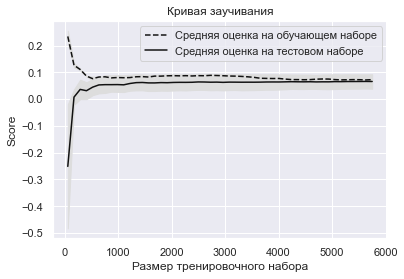

In [55]:
# проверяю, насколько оценка 
# зависит от размера тренировочного набора
train_sizes, train_scores, test_scores = learning_curve(LinearRegression(), 
                                                        X_train,
                                                        y_train,
                                                        cv=10,
                                                        train_sizes=np.linspace(0.01, 1.0, 50))


train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


plt.plot(train_sizes, train_scores_mean, '--', color='#111111', label='Средняя оценка на обучающем наборе') 
plt.plot(train_sizes, test_scores_mean, color="#111111", label='Средняя оценка на тестовом наборе')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='#DDDDDD')
plt.fill_between(train_sizes, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std, color='#DDDDDD')

plt.title('Кривая заучивания')
plt.xlabel('Размер тренировочного набора')
plt.ylabel('Score')
plt.legend(loc='best')
#plt.tight_layout()
plt.show()

Вот интерпретация графика.

Пунктирная линия - оценка на обучающем наборе. Чем больше данных, тем хуже оценка. Значит есть значительное смещение.

Сплошная линия - оценка на тестовом наборе. Чем больше данных, тем выше оценка. Однако эта оценка стабилизируется на значении 0.9 и не изменяется с добавлением новых данных.

Дисперсия небольшая, разрыв между линиями маленький.

Таким образом, модель недобучена на обучающих данных.

При интепретации этого графика надо учитывать следующие правила. Кривая оценки эффективности для обучения близка к оценки эффективности для проверки - это недообученная модель. Одна кривая сильно отстает от другой - переобученная (дисперсия, разброс большой). Лучший вариант - по середине.

# Полиномиальная регрессия

Полиноминальная регрессия, по своей сути, это создание дополнительных признаков из имеющихся и подгонка регрессии. Переменные создаются достаточно прямолинейно: имеющиеся возвоздятся в квадрт (куб или любую иную степень) и(или) перемножаются. Это не тоже самое создание переменных, которым я занимался раньше. Когда я создавал, например, признак по наличию соавтора/переводчика, то делал это вполне осознанно, предполагая, что наличие соавтора вполне может повлиять на качество переведенной книги. В случае же с полиномиальной регрессией приходится довериться простым математическим операциям.

In [56]:
interaction = PolynomialFeatures(3, include_bias=False)
X_interaction = interaction.fit_transform(X_train)
regression = LinearRegression()
model = regression.fit(X_interaction, y_train)
model.score(X_interaction, y_train)
X_predict_interaction = model.predict(X_interaction)
lin_mse = mean_squared_error(y_train, X_predict_interaction)
lin_mse 

0.07500072219114433

# Регуляризация

## Ridge

Основная цель регуляризации - бороться с переобучением. Если модель слишком хорошо будет подогнана к тренировочным данным, то плохо будет обобщаться на тестовые и реальные данные. Hо регуляризация, добавляя неопределенности в данные, готовит модель к встречи с реальностью.

Регуляризация позволяет отыскать компромисс между дисперсией и смещением. Также регуляризация позволяет бороться с коллинеарностью в данных. Работает регуляризация только при наличии предварительного масштабирования.

Из учебника Машинное обучение: "Мы можем думать о регуляризации как о добавлении к функции издержек члена штрафа, чтобы поддерживать меньшие веса; другими словами, мы штрафуем крупные веса. Таким образом, за счет увеличения силы регуляризации через параметр регуляризации лямбда мы уменьшаем веса в сторону нуля и сокращаем зависимость модели от обучающих данных".

На практике сформулированы следующие правила регуляризации:

1) рекомендуется во всех случаях использовать регуляризацию, избегать обычную регрессию;
2) гребневая регуляризация является лучшим выбором по умолчанию;
3) однако, если есть основания полагать, что только несколько переменных имеют влияние на зависимую переменную, то рекомендуется использовать лассо-регуляризацию или эластичную регуляризацию. При этом, как правило, эластичная показывает себя лучше, чем лассо.

Больше про регуляризацию можно найти в гл. 3.4, гл. 3.8 учебника Основы обучения, а также из главы [4.5. Weight Decay](https://d2l.ai/chapter_multilayer-perceptrons/weight-decay.html).

In [57]:
regression = Ridge(alpha=0.5)
model = regression.fit(X_train, y_train)
pred_b = model.predict(X_test)
mse = mean_squared_error(y_test, pred_b)
mse 

# попробуем улучшить модель
regr_cv = RidgeCV(alphas=[0.1, 1.0, 10.0])
model_cv = regr_cv.fit(X_train, y_train)
model_cv.alpha_ 
regression = Ridge(alpha=10)
model = regression.fit(X_train, y_train)
pred_b = model.predict(X_test)
mse = mean_squared_error(y_test, pred_b)
mse 

0.07481613876238447

# Lasso

In [58]:
regression = Lasso(alpha=10)
model_l = regression.fit(X_train, y_train)
model_predict = model_l.predict(X_test)
mse = mean_squared_error(y_test, model_predict)
mse

0.08056779550972057

# Приложение 1 Дополнительные материалы

**Рекомендуемая литература:**

1) Сара Бослаф Статистика для всех
2) П. Брюс Практическая статистика для специалистов Data Science
3) С. Рашка, В. Мирджалили Python и машинное обучение (по тексту - учебник Машинное обучение)
4) Дэвидсон, Мак-Кинон Теория и методы эконометрики (по тексту - учебник Дэвидсона)
5) Тревор Хасти, Роберт Тибширани, Джером Фридман Основы статистического обучения (по тексту - учебник Основы обучения)
6) [Dive into deep learning](https://d2l.ai/chapter_preface/index.html) (по тексту - онлайн учебник ML)

**Полезные ссылки:**

1) хорошее описание статистических процедур [PYTHON FOR DATA SCIENCE. LINEAR REGRESSION](https://www.pythonfordatascience.org/linear-regression-python/)
2) [OLS Regression: Boston Housing Dataset](https://www.datasklr.com/ols-least-squares-regression/ols-regression-boston-housing-dataset)
3) хорошее введение в линейную алгебру [здесь](https://pabloinsente.github.io/intro-linear-algebra#matrix-decompositions)
4) руководство по применению регулярных выражений [здесь](https://developers.google.com/edu/python/regular-expressions);
5) еще одно руководство по регулярным выражениям от проекта [Dataquest](https://www.dataquest.io/blog/regular-expressions-data-scientists/)
6) и еще немного про регулярные выражения от [Towards Data Science](https://towardsdatascience.com/easiest-way-to-remember-regular-expressions-regex-178ba518bebd)
7) математическая энциклопедия от проекта [Wolfram](https://mathworld.wolfram.com/)

**Ссылки на мои ресурсы:**

1) Twitter https://twitter.com/runaz_there
2) GitHub https://github.com/Ruslan-Nazarov
3) AI for everyone (Medium) https://medium.com/ai-for-everyone
4) LinkedIn https://www.linkedin.com/in/ruslan-nazarov-223003198/
5) email runaz2007@gmail.com OR runaz@protonmail.com

В последующих редакциях:
1) будет значительно улучшен раздел про выбросы.

# Приложение 2

Здесь я постараюсь дать более интуитивное представление о машинном обучении.

Начну с цели. Чего я хочу добиться с помощью машинного обучения? Например, я хочу показать машине фотографию и жду, что машина укажет, кто представлен на фотографии. Таким образом, уже из этого я улавливаю, что есть признаки (фотография) и целевой признак (кто представлен на фотографии). Но чтобы машина на основании показанной фотографии угадывала тех, кто на ней представлен, надо ее обучить в том же порядке: показать какую-то другую фотографию и указать, кто на ней представлен. Покажу машине сотни и тысячи таких фотографий с различными изображениями одних и тех же лиц, для каждой фотографии укажу, кто изображен. Это будет обучением. Затем покажу фотографию, но уже не буду указывать, кто изображен. Пусть машина сама угадывает. В этом состоит смысл машинного обучения.

Теперь предположим, что я хочу похвастаться своей машиной перед друзьями. Пускай друзья принесут свои фотографии, которые не то что машина не видела, но даже и друзья не видели. Я хотчу быть уверен, что машина не подведет. Что это означает? Это означает, что машине перед приходом друзей нужно устроить экзамен. Я обучал машину, скажем, на 100 фотографиях, а затем просил ее угадать, кто изображен на фото, но только на одном фото. Усложню задачу и покажу не одну фотографию, а, скажем, 30. Угадает ли машина? В одних случаях - да, в других - нет. Сколько таких случаев? Где машина ошибалась?

Итак, я получил три этапа: я обучал машину на 100 фотографиях, затем проверял на 30, а затем могу принимать друзей и устраивать машине серьезную проверку. Это и составляет этапы машинного обучения: тренировку, тестирование, применение к реальным данным.

С этапами разобрались. Теперь начнем с тренировки. Раз я показываю фотографии и жду ответа от машины, значит надо решить несколько задач. Я должен выбрать собственно ту машину, которая будет обучаться. Далее я должен сравнить наши тестовые данные с требованиями, которые предъявляются для тренировочных данных этой конкретной разновидности машины. Определившись с этим я должен исправить или улучшить данные так, чтобы они подходили под выбранную модель обучения. Кроме того, я дожен разбить данные на две (или на три - в идеале) части: тренировочную и тестовую. 

Теперь я готов к обучению модели. Каждая модель определяется набором гиперпараметров. Изначально я не изменяю параметры. Провожу обучение на тренировочных данных. После этого использую тестовые данные для оценки модели. Если все устраивает, то можно выпускать модель в реальную жизнь. Не устраивает? Тогда начинаю настройку: изменяю параметры модели, собираю дополнительные данные, изменяю, улучшаю данные. После этого опять провожу обучение и оценку. Устраивает? Пользуюсь. Не устраивает? Еще раз настраиваю. И так, пока результат оценки не устроит.

Вот еще несколько полезных инструментов машинного обучения.

1) Pipline. На первом этапе надо убедиться, что данные подходят для модели обучения, или улучшить их так, чтобы они подходили. Далее применяюю модель обучения. Предположу, что данные требуют доработки. Тогда можно применить различные способа обработки к данным последовательно с помощью этого инструмента. Кроме того, после обработки, в том же инструменте, можно применить и разные модели обучения (или одну, если я уже точно определился). Все это делается просто через составление словаря, который содержит набор строк, каждая из которых отражает конкретный способ обработки данных и модель обучения.

2) GridSearch. Это поиск по сетке. Изначально обучаю модель на параметрах, установленных по умолчанию. Если результат неудовлетворительный, то надо отыскать такие параметры, которые устроят. Как это сделать? Желательно создать десятки или даже сотни моделей, но чтобы у каждого экземпляра модели был свой набор параметров. Каждую такую модель надо обучить и провести оценку. Найду лучшую оценку, возьму те параметры, с которыми модель выдала эту лучшую оценку. Именно эту задачу решает поиск по сетке. Представлю таблицу. Строки - это модели. Столбцы - настраиваемые параметры. Заполняю ячейки теми значениями, которые хочу проверить. Далее беру каждую строку, обучаю, оцениваю. 

3) CV. Кросс-валидация. Может применяться в составе GridSearch или отдельно. Суть заключается в том, что многократно разделяю набор данных на тренировочный и тестовый. На каждом полученном наборе провожу обучение, оценку. Смотрю, какой наилучший вариант можно получить.
